In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f
from scipy.optimize import minimize_scalar
import seaborn as sns

# Настройка стиля графиков
plt.style.use('seaborn-v0_8-pastel')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.grid'] = True

# Параметры исследования
params = {
    'length': {'sigma1': 5.722, 'sigma2': 6.161, 'n1': 139, 'n2': 1000},
    'width': {'sigma1': 4.612, 'sigma2': 5.055, 'n1': 139, 'n2': 1000}
}

In [3]:
def calculate_f_test(sigma1, sigma2, n1, n2, alpha=0.05):
    """Вычисляет F-статистику и критическую область"""
    F_value = (sigma1 ** 2) / (sigma2 ** 2)
    df1, df2 = n1 - 1, n2 - 1
    
    # Критические значения
    F_crit = {
        'lower': f.ppf(alpha/2, df1, df2),
        'upper': f.ppf(1 - alpha/2, df1, df2)
    }
    
    # P-значения (двусторонний тест)
    p_value = 2 * min(f.cdf(F_value, df1, df2), 1 - f.cdf(F_value, df1, df2))
    
    return F_value, F_crit, p_value, df1, df2

# Вычисляем результаты для длины и ширины
results = {}
for key in params:
    res = calculate_f_test(**params[key])
    results[key] = {
        'F_value': res[0],
        'F_crit': res[1],
        'p_value': res[2],
        'df': (res[3], res[4])
    }
    print(f"\nРезультаты для {key}:")
    print(f"F-статистика: {results[key]['F_value']:.4f}")
    print(f"Критическая область: ({results[key]['F_crit']['lower']:.4f}, {results[key]['F_crit']['upper']:.4f})")
    print(f"P-значение: {results[key]['p_value']:.4g}")


Результаты для length:
F-статистика: 0.8626
Критическая область: (0.7674, 1.2717)
P-значение: 0.2728

Результаты для width:
F-статистика: 0.8324
Критическая область: (0.7674, 1.2717)
P-значение: 0.1732


In [5]:
# Визуализация распределения F-статистики
def plot_f_distribution(df1, df2, F_values, F_crit, labels):
    x = np.linspace(0, 2, 500)
    y = f.pdf(x, df1, df2)
    
    plt.figure(figsize=(12, 7))
    plt.plot(x, y, label=f'F-распределение (df1={df1}, df2={df2})', linewidth=2)
    
    # Критические области
    plt.axvspan(0, F_crit['lower'], color='red', alpha=0.2, label='Критическая область')
    plt.axvspan(F_crit['upper'], max(x), color='red', alpha=0.2)
    
    # F-статистики
    colors = ['green', 'blue']
    for F_val, color, label in zip(F_values, colors, labels):
        plt.axvline(x=F_val, color=color, linestyle='--', 
                   linewidth=2, label=f'{label} (F={F_val:.3f})')
    
    plt.title('F-распределение и результаты теста', pad=20)
    plt.xlabel('Значение F-статистики')
    plt.ylabel('Плотность вероятности')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [7]:
# График мощности теста
def plot_power_curve(df1, df2, F_crit, alpha=0.05):
    lambda_vals = np.linspace(0.5, 2, 150)
    
    def power_function(lam):
        return 1 - f.cdf(F_crit['upper'], df1, df2, scale=lam) + \
               f.cdf(F_crit['lower'], df1, df2, scale=lam)
    
    power = np.vectorize(power_function)(lambda_vals)
    
    # Найдем точку, где мощность достигает 80%
    target_power = 0.8
    res = minimize_scalar(lambda x: abs(power_function(x) - target_power), 
                         bounds=(0.5, 2), method='bounded')
    
    plt.figure(figsize=(12, 7))
    plt.plot(lambda_vals, power, linewidth=2, 
            label=f'Мощность критерия (α={alpha})')
    plt.axvline(x=1, color='red', linestyle=':', 
               label='Нулевая гипотеза (σ₁² = σ₂²)')
    
    if res.success:
        plt.scatter(res.x, target_power, color='purple', s=100,
                  label=f'Мощность 80% при λ = {res.x:.3f}')
        plt.axhline(y=target_power, color='gray', linestyle='--', alpha=0.5)
    
    plt.title('Кривая мощности F-теста', pad=20)
    plt.xlabel('Отношение дисперсий (σ₂²/σ₁²)')
    plt.ylabel('Мощность критерия')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


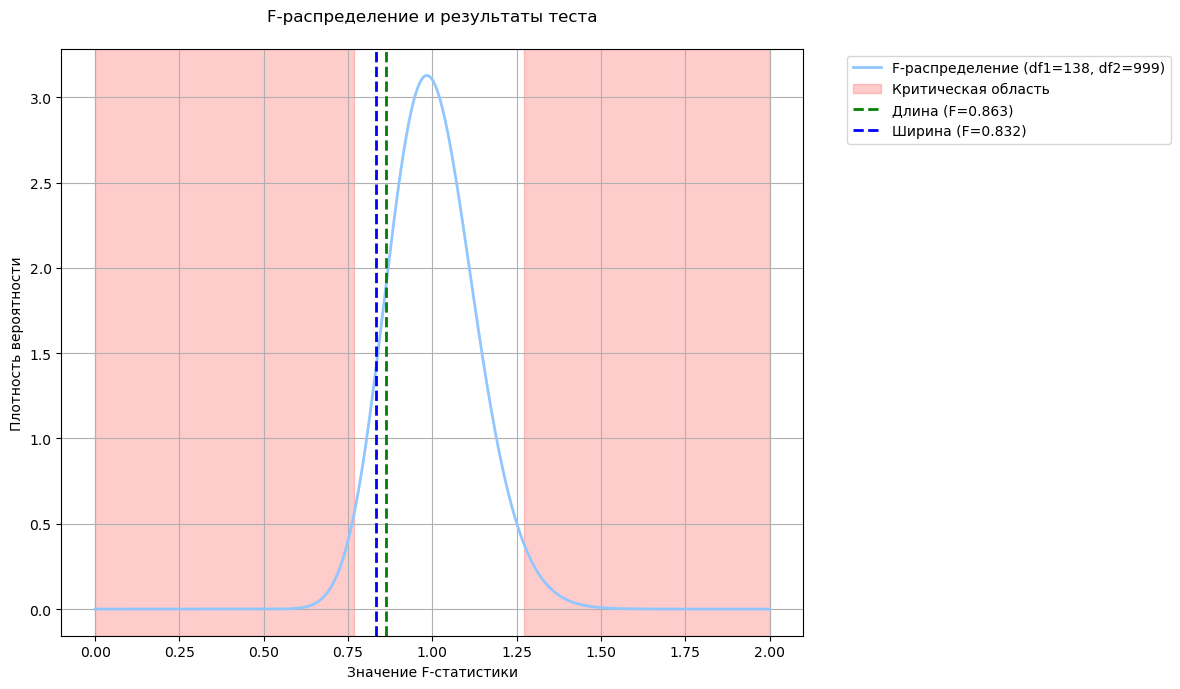

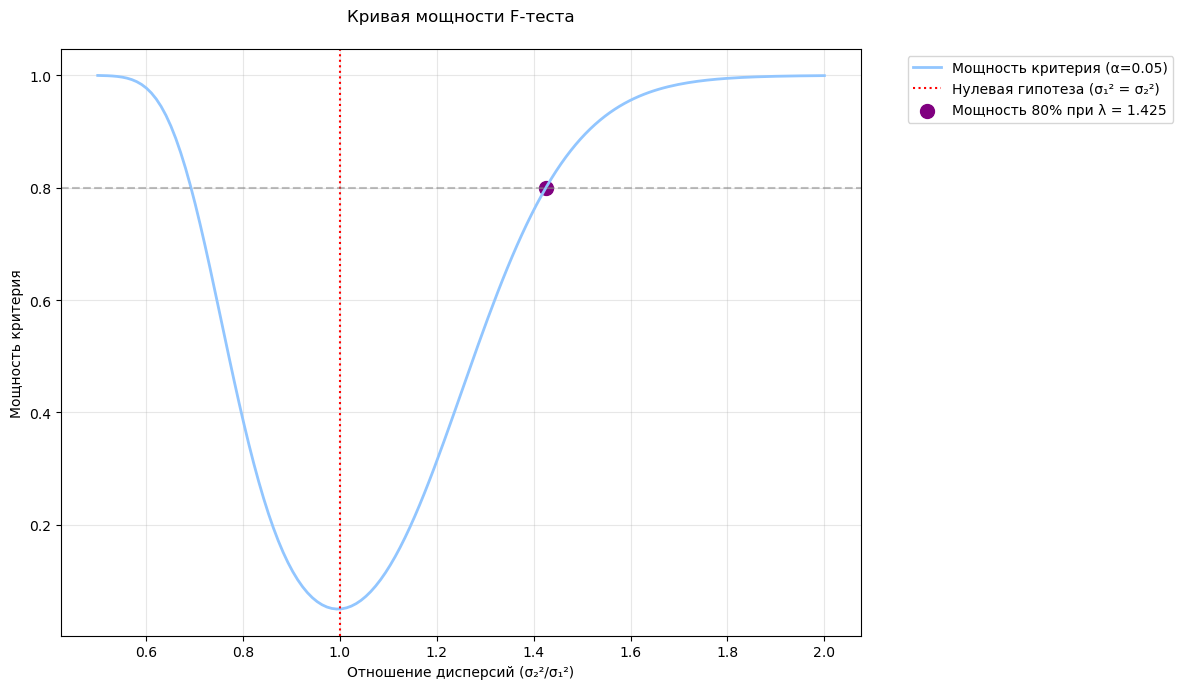

In [9]:
# Строим графики
F_values = [results['length']['F_value'], results['width']['F_value']]
labels = ['Длина', 'Ширина']
plot_f_distribution(results['length']['df'][0], results['length']['df'][1], 
                   F_values, results['length']['F_crit'], labels)

plot_power_curve(results['length']['df'][0], results['length']['df'][1], 
                results['length']['F_crit'])